In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import random
import io 
import PIL 
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = numpy.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = numpy.array(snapshot.particles.orientation)
    angles = 2 * numpy.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
m = 5
N_particles = m**2
spacing = 2
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.orientation = orientation[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Squares']


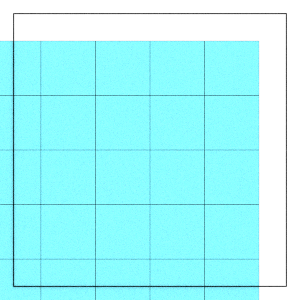

In [4]:
render(frame)

In [5]:
fn = os.path.join(os.getcwd(), 'lattice_sq_v3.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_sq_v3.gsd', mode='x') as f:
    f.append(frame)

In [3]:
cpu = hoomd.device.CPU()

Flow 

- Have a compressed system 
- Set betaP to 1 inititially 
- Simulation:
    - Record Volume fraction for each timestep 
    - Pressure should remain constant 
    - Only run simulation until the volume fraction stabilizes within a reasonable error 
    - Take average of volume fraction at the last few timesteps after the simulation stabilizes (after transition state)
- Increase betaP by 1
- Repeat Simulation process and store the constant Pressure and volume fraction with the error after average of last few is taken
- Repeat until target volume fraction is reached

In [35]:
def expand(simulation, initial_betaP, target_vf, s, run_steps, log_interval=100, stabilization_threshold=1e10-1, avg_steps=1000):
    simulation.create_state_from_gsd(filename='lattice_sq_v3.gsd')

    fn = os.path.join(os.getcwd(), 'trajectory_expansion_v3.gsd')
    ![ -e "$fn" ] && rm "$fn"

    gsd_writer = hoomd.write.GSD(
        filename='trajectory_expansion_v3.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
    )
    simulation.operations.writers.append(gsd_writer)

    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices=[
            (-1, -1),
            (1, -1),
            (1, 1),
            (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    volume_particle = s ** 2
    current_betaP = initial_betaP
    results = []

    while True:
        # Set up BoxMC with the current betaP
        boxmc = hoomd.hpmc.update.BoxMC(
            trigger=50,
            betaP=current_betaP            
        )

        boxmc.volume = dict(
            mode='standard',
            weight=0.5,
            delta=-1
        )

        tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
            trigger=50,
            moves=['d', 'a'],
            target=0.2,
            max_translation_move=1,
            max_rotation_move=0.2
        )

        tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
            trigger=50,
            boxmc=boxmc,
            moves=['volume'],
            target=0.5,
            max_move_size= {'volume':1000}
        )

        simulation.operations.tuners.append(tune1)
        simulation.operations.tuners.append(tune2)
        simulation.operations.updaters.append(boxmc)

        volume_fractions = []
        pressures = []
        stable = False

        # Run the simulation until volume fraction stabilizes
        for step in range(0, run_steps, log_interval):
            simulation.run(log_interval)

            current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
            volume_fractions.append(current_vf)
            pressures.append(current_betaP)

            if len(volume_fractions) > avg_steps // log_interval:
                recent_vfs = volume_fractions[-(avg_steps // log_interval):]
                vf_mean = numpy.mean(recent_vfs)
                vf_std = numpy.std(recent_vfs)

                # Check stabilization threshold
                if vf_std / vf_mean < stabilization_threshold:
                    stable = True
                    break

        # Compute the average and error after stabilization
        if stable:
            avg_vf = numpy.mean(recent_vfs)
            vf_error = vf_std
            results.append((current_betaP, avg_vf, vf_error))

            # Only print if current_betaP is divisible by 2
            if current_betaP % 1 == 0:
                if len(results) == 1:
                    print(f"{'betaP':<6} | {'Avg VF':<12} | {'Error':<12}")
                    print("-" * 40)

                # Print the current result
                print(f"{current_betaP:<6} | {avg_vf:<12.4f} | {vf_error:<12.4f}")

            # Stop if target volume fraction is reached
            if avg_vf <= target_vf:
                break

            # Increment betaP for the next iteration
            if current_betaP > (-10) :
                current_betaP -= 1
            else:
                break

        else:
            print("Failed to stabilize within given steps. Consider increasing run_steps or adjusting parameters.")
            break
    
    gsd_writer.flush()

    return results


In [ ]:
simulation = hoomd.Simulation(device=cpu, seed=17)

results = expand(initial_betaP=50, target_vf=0.5, s=2, run_steps=30_00000, simulation=simulation)

betaP  | Avg VF       | Error       
----------------------------------------
50     | 1.0000       | 0.0000      
49     | 1.0000       | 0.0000      
48     | 1.0000       | 0.0000      
47     | 1.0000       | 0.0000      
46     | 1.0000       | 0.0000      
45     | 1.0000       | 0.0000      
44     | 1.0000       | 0.0000      
43     | 0.9998       | 0.0002      
42     | 0.9987       | 0.0002      
41     | 0.9976       | 0.0004      
40     | 0.9968       | 0.0006      
39     | 0.9962       | 0.0004      
38     | 0.9944       | 0.0003      
37     | 0.9944       | 0.0002      
36     | 0.9936       | 0.0009      


*Warning*: Exceeded sanity limit for image list, generated out to 31 lattice vectors. Logic error?
This message will not be repeated.
*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 3969 images per trial move, performance may slow.
This message will not be repeated.


In [5]:
simulation = hoomd.Simulation(device=cpu, seed=17)

results = expand(initial_betaP=50, weight=3, delta=-5, target_vf=0.5, s=2, run_steps=30_00000, simulation=simulation)

TypeError: expand() got an unexpected keyword argument 'weight'

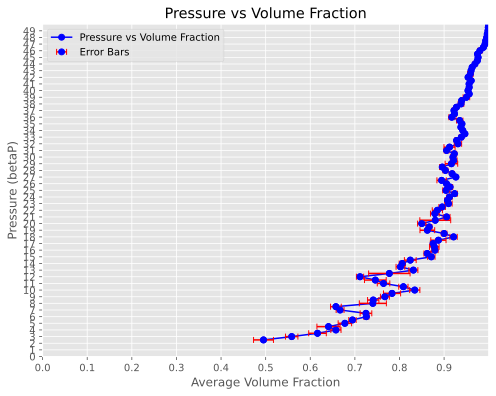

In [107]:
# Extract the betaP and avg_vf values
betaP_values = [result[0] for result in results]
avg_vf_values = [result[1] for result in results]

# Create the plot with volume fraction on the x-axis and pressure on the y-axis
plt.figure(figsize=(8, 6))
plt.plot(avg_vf_values, betaP_values, marker='o', linestyle='-', color='b', label='Pressure vs Volume Fraction')

# Add labels and title
plt.xlabel('Average Volume Fraction')
plt.ylabel('Pressure (betaP)')
plt.title('Pressure vs Volume Fraction')

# Optional: Add error bars if needed
vf_errors = [result[2] for result in results]
plt.errorbar(avg_vf_values, betaP_values, xerr=vf_errors, fmt='o', color='b', ecolor='r', capsize=3, label='Error Bars')

plt.xlim(0, 1.0)
plt.ylim(0,50)
plt.xticks(numpy.arange(0, 1.0, 0.1))
plt.yticks(numpy.arange(0, 50, 1))

# Display the plot
plt.legend()
plt.grid(True)
plt.show()


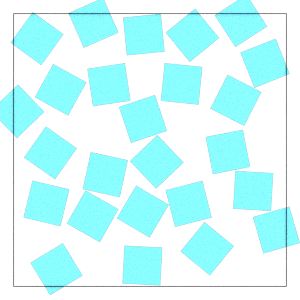

In [108]:
render(simulation.state.get_snapshot())

In [120]:
del(simulation)

In [ ]:
###################
###################
####COMPRESSION####
###################
###################


In [116]:
m = 5
N_particles = m ** 2
spacing = 20  
target_vf = 0.01 

particle_radius = 1 
particle_volume = (2 * particle_radius) ** 2  
box_volume = N_particles * particle_volume / target_vf
box_size = numpy.sqrt(box_volume) 

positions = numpy.random.uniform(-box_size / 2, box_size / 2, size=(N_particles, 2))
positions = [(px, py, 0) for px, py in positions]  

orientations = [(numpy.cos(random.uniform(0, 2 * numpy.pi)), 
                 numpy.sin(random.uniform(0, 2 * numpy.pi)), 
                 0, 0) for _ in range(N_particles)] 

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = positions
frame.particles.orientation = orientations
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [box_size, box_size, 0, 0, 0, 0]
frame.particles.types = ['Squares']

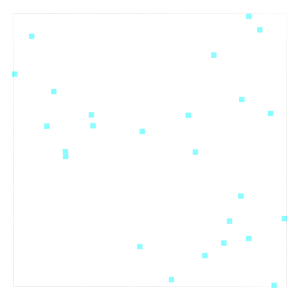

In [117]:
render(frame)

In [118]:
fn = os.path.join(os.getcwd(), 'lattice_sq_v3_cmp.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_sq_v3_cmp.gsd', mode='x') as f:
    f.append(frame)

In [4]:
def compress(simulation, initial_betaP, target_vf, s, run_steps, log_interval=100, stabilization_threshold=1e-1, avg_steps=1000):
    simulation.create_state_from_gsd(filename='lattice_sq_v3_cmp.gsd')

    fn = os.path.join(os.getcwd(), 'trajectory_compression_v3.gsd')
    ![ -e "$fn" ] && rm "$fn"

    gsd_writer = hoomd.write.GSD(
        filename='trajectory_compression_v3.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
    )
    simulation.operations.writers.append(gsd_writer)

    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices=[
            (-1, -1),
            (1, -1),
            (1, 1),
            (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    volume_particle = s ** 2  # Assuming square particles with side length 's'
    current_betaP = initial_betaP
    results = []

    while True:
        # Set up BoxMC with the current betaP
        boxmc = hoomd.hpmc.update.BoxMC(
            trigger=hoomd.trigger.Periodic(10),
            betaP=current_betaP
        )

        boxmc.volume = dict(
            mode='standard',
            weight=0.75,
            delta=10000
        )

        simulation.operations.updaters.append(boxmc)

        volume_fractions = []
        pressures = []
        stable = False

        # Run the simulation until volume fraction stabilizes
        for step in range(0, run_steps, log_interval):
            simulation.run(log_interval)

            current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
            volume_fractions.append(current_vf)
            pressures.append(current_betaP)

            if len(volume_fractions) > avg_steps // log_interval:
                recent_vfs = volume_fractions[-(avg_steps // log_interval):]
                vf_mean = numpy.mean(recent_vfs)
                vf_std = numpy.std(recent_vfs)

                # Check stabilization threshold
                if vf_std / vf_mean < stabilization_threshold:
                    stable = True
                    break

        # Compute the average and error after stabilization
        if stable:
            avg_vf = numpy.mean(recent_vfs)
            vf_error = vf_std
            results.append((current_betaP, avg_vf, vf_error))

            # Only print if current_betaP is divisible by 2
            if current_betaP % 1 == 0:
                if len(results) == 1:
                    print(f"{'betaP':<6} | {'Avg VF':<12} | {'Error':<12}")
                    print("-" * 40)

                # Print the current result
                print(f"{current_betaP:<6} | {avg_vf:<12.4f} | {vf_error:<12.4f}")

            # Stop if target volume fraction is reached
            if avg_vf >= target_vf:
                break

            # Increment betaP for the next iteration
            if current_betaP < 10000:
                current_betaP += 1
            else:
                break

        else:
            print("Failed to stabilize within given steps. Consider increasing run_steps or adjusting parameters.")
            break
    
    gsd_writer.flush()

    return results


In [5]:
simulation = hoomd.Simulation(device=cpu, seed=17)

results = compress(initial_betaP=1000, target_vf=0.7, s=2, run_steps=30_00000, simulation=simulation)

betaP  | Avg VF       | Error       
----------------------------------------
1000   | 0.0100       | 0.0000      
1001   | 0.0100       | 0.0000      
1002   | 0.0100       | 0.0000      
1003   | 0.0100       | 0.0000      
1004   | 0.0100       | 0.0000      
1005   | 0.0100       | 0.0000      
1006   | 0.0100       | 0.0000      
1007   | 0.0100       | 0.0000      
1008   | 0.0100       | 0.0000      
1009   | 0.0100       | 0.0000      
1010   | 0.0100       | 0.0000      
1011   | 0.0100       | 0.0000      
1012   | 0.0100       | 0.0000      
1013   | 0.0100       | 0.0000      
1014   | 0.0100       | 0.0000      
1015   | 0.0100       | 0.0000      
1016   | 0.0100       | 0.0000      
1017   | 0.0100       | 0.0000      
1018   | 0.0100       | 0.0000      
1019   | 0.0100       | 0.0000      
1020   | 0.0100       | 0.0000      
1021   | 0.0100       | 0.0000      
1022   | 0.0100       | 0.0000      
1023   | 0.0100       | 0.0000      
1024   | 0.0100       | 0.0000    

*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 21 images per trial move, performance may slow.
This message will not be repeated.


1036   | 0.0100       | 0.0000      
1037   | 0.0100       | 0.0000      
1038   | 0.0100       | 0.0000      
1039   | 0.0100       | 0.0000      
1040   | 0.0100       | 0.0000      
1041   | 0.0100       | 0.0000      
1042   | 0.0100       | 0.0000      
1043   | 0.0100       | 0.0000      
1044   | 0.0100       | 0.0000      
1045   | 0.0100       | 0.0000      
1046   | 0.0100       | 0.0000      
1047   | 0.0100       | 0.0000      
1048   | 0.0100       | 0.0000      
1049   | 0.0100       | 0.0000      
1050   | 0.0100       | 0.0000      
1051   | 0.0100       | 0.0000      
1052   | 0.0100       | 0.0000      
1053   | 0.0100       | 0.0000      
1054   | 0.0100       | 0.0000      
1055   | 0.0100       | 0.0000      
1056   | 0.0100       | 0.0000      
1057   | 0.0100       | 0.0000      
1058   | 0.0100       | 0.0000      
1059   | 0.0100       | 0.0000      
1060   | 0.0100       | 0.0000      
1061   | 0.0100       | 0.0000      
1062   | 0.0100       | 0.0000      
1

KeyboardInterrupt: 